In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import process_model as pm

%load_ext autoreload
%autoreload 2

In [2]:
inverted_pendulum = pm.InvertedPendulum(
    1.0,
    2.0,
    30.0,
    0.4,
    5.0,
)

(inverted_pendulum.dynamics_continuous([0,0,0,0], [0])).shape

(4,)

In [3]:
timespan = 20
Ts = 0.01
initial_state = np.array([0.0, 0.0, 0.01, 0.0])

simulator = pm.PlantSimulator(
    plant=inverted_pendulum.dynamics_continuous,
    timestep=Ts,
    simulation_time=timespan,
)

#TODO: test if integration still works as expected after refactor.
# state_evolution, t = inverted_pendulum.simulate_system(initial_state, timespan, Ts)

# inverted_pendulum.plot_state_evolution(state_evolution, t)

In [4]:
process_dynamics = inverted_pendulum.dynamics_continuous_sym()
dynamics_jacobian_x = process_dynamics.jacobian(sp.symbols("x1:5"))
A_c = dynamics_jacobian_x.evalf(subs={'x1': 0.0, 'x2': 0.0, 'x3':0.0, 'x4':0.0})
A_c = np.array(A_c).astype(np.float64)

dynamics_jacobian_u = process_dynamics.jacobian([sp.symbols("u")])
B_c = dynamics_jacobian_u.evalf(subs={'x1': 0.0, 'x2': 0.0, 'x3':0.0, 'x4':0.0})
B_c = np.array(B_c).astype(np.float64)

In [5]:
# Euler forward discretization of system
A_d = np.eye(A_c.shape[0]) + Ts * A_c
B_d = Ts * B_c

# LQR Controller Design
## Wikipedia:
the optimal control sequence minimizing the performance index is given by:
$$
u_{k}=-Fx_{k}\,
$$
where:
$$
F=(R+B^{T}PB)^{{-1}}(B^{T}PA+N^{T})\,
$$
and $P$ is the unique positive definite solution to the discrete time algebraic Riccati equation (DARE). $P$ can be found by iterating the dynamic Riccati equation until it converges:
$$
P_{{k-1}}=A^{T}P_{k}A-(A^{T}P_{k}B+N)\left(R+B^{T}P_{k}B\right)^{{-1}}(B^{T}P_{k}A+N^{T})+Q
$$ 
from terminal condition $P_{N}=Q$.

In [6]:
R = 1
Q = np.eye(A_d.shape[0])
Q[0,0] = Q[2,2] = 1000

P = Q

while True:
    P_new = A_d.transpose() @ P @ A_d - (A_d.transpose() @ P @ B_d) @ np.linalg.inv(R + B_d.transpose() @ P @ B_d) @ (B_d.transpose() @ P @ A_d) + Q
    if np.linalg.norm(P-P_new) < 1e-5:
        P = P_new
        break
    else:
        P = P_new
        
print(P)

[[  206735.65963734   212606.48660443   974297.39071374   311232.09835371]
 [  212606.48660443   336810.60033104  1693245.06588307   540918.65328672]
 [  974297.39071374  1693245.06588307 14848105.49531863  4671986.50159062]
 [  311232.09835371   540918.65328672  4671986.50159062  1472038.00099734]]


[[ -30.41806227  -63.2849817  -948.34028801 -296.36238705]]


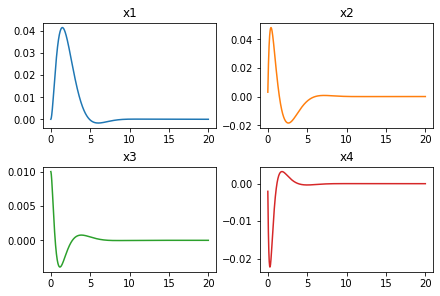

In [8]:
F_inf = np.linalg.inv(R + B_d.transpose() @ P @ B_d) @ (B_d.transpose() @ P @ A_d)

print(F_inf)

#return the element in the array and not the array itself to avoid a warning
lqr_controller = lambda x: (-F_inf @ x)[0]

inverted_pendulum.set_controller(lqr_controller)

state_evolution, t = inverted_pendulum.simulate_system(initial_state, timespan, Ts)

inverted_pendulum.plot_state_evolution(state_evolution, t)

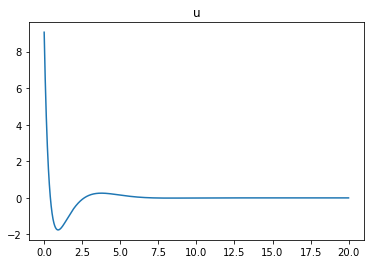

In [9]:
inverted_pendulum.plot_actuator_commands(state_evolution, t)